In [1]:
!pip install wget torchinfo
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=4b91b5acacf5c8d64b61c69f9bf9bef1fd12edfb61bc166431da2e6acfdbd28c
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
--2025-01-18 07:26:59--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-01-18 07:26:59--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>]  

In [2]:
!wget -O CRC-VAL-HE-7K.zip https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
!unzip -qq CRC-VAL-HE-7K.zip -d val

--2025-01-18 07:38:52--  https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800276929 (763M) [application/octet-stream]
Saving to: ‘CRC-VAL-HE-7K.zip’

CRC-VAL-HE-7K.zip   100%[===================>] 763.20M  24.9MB/s    in 33s     

2025-01-18 07:39:26 (23.0 MB/s) - ‘CRC-VAL-HE-7K.zip’ saved [800276929/800276929]



In [3]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary

In [4]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [5]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x


In [6]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [7]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [8]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [9]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [10]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x


In [11]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [12]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [13]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [14]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=4, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=4, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [15]:
model = LevitDistilled()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 5e-4
decay_rate = 1e-6
num_epochs = 30

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [16]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [17]:
import random
import torchvision.transforms.functional as TF

class DataAugmentation:
    def __init__(self, p_hflip=0.5, p_vflip=0.5, p_noise=0.2, p_blur=0.2, p_color=0.2, p_contrast=0.2):
        self.p_hflip = p_hflip
        self.p_vflip = p_vflip
        self.p_noise = p_noise
        self.p_blur = p_blur
        self.p_color = p_color
        self.p_contrast = p_contrast
    def __call__(self, img):
        if random.random() < self.p_hflip:
            img = TF.hflip(img)

        if random.random() < self.p_vflip:
            img = TF.vflip(img)

        if random.random() < self.p_noise:
            # img.size is a tuple, so unpack it as arguments for torch.randn
            noise = torch.randn(*img.size()) * 0.1  # Changed img.size() to img.size
            img = torch.clamp(img + noise, 0, 1)

        if random.random() < self.p_blur:
            img = TF.gaussian_blur(img, kernel_size=(5, 5), sigma=(0.1, 5))

        if random.random() < self.p_color:
            img = TF.adjust_saturation(img, saturation_factor = random.uniform(0.5, 1.5))

        if random.random() < self.p_contrast:
            img = TF.adjust_contrast(img, contrast_factor = random.uniform(0.5, 1.5))

        return img

In [18]:
import torch
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# 데이터셋 경로
dataset_dir = './train/NCT-CRC-HE-100K'

# 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    DataAugmentation(),
])

# Using StratifiedShuffleSplit from sklearn

dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)
data_paths, labels = zip(*dataset.samples)
labels = np.array(labels)

# 7 : 3 split
train_idx, tmp_idx, _, tmp_labels = train_test_split(
    np.arange(len(labels)), labels, test_size=0.3, stratify=labels, random_state=42
)

# 3 -> 1.5 : 1.5 split
val_idx, test_idx = train_test_split(
    tmp_idx, test_size=0.5, stratify=tmp_labels, random_state=42
)

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

In [19]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


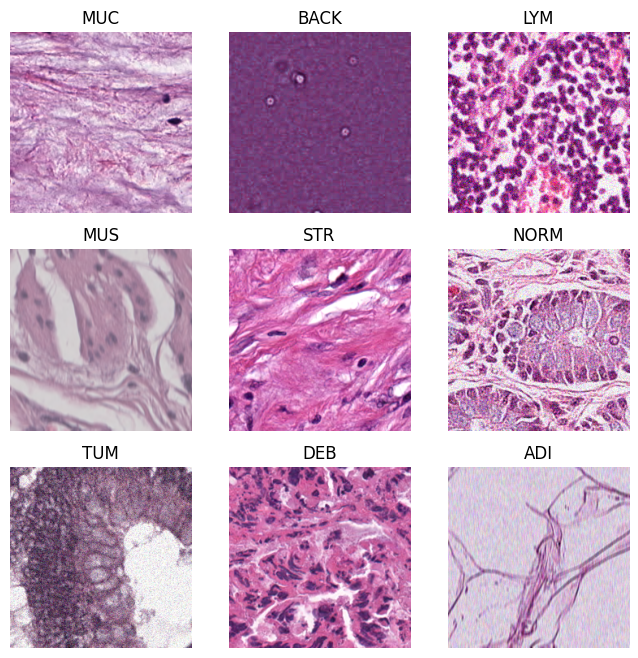

In [20]:
# Show one example per class from the training dataset
import matplotlib.pyplot as plt

# Prepare a dictionary to store one example per class
class_examples = {}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if label not in class_examples:
            class_examples[label] = img
        # Stop if we already have one example for each class
        if len(class_examples) == len(dataset.classes):
            break
    if len(class_examples) == len(dataset.classes):
        break

# Display the images and their labels
figure = plt.figure(figsize=(8, 8))
cols = 3  # You can adjust the number of columns as needed
rows = (len(dataset.classes) + cols - 1) // cols  # Calculate required rows
for i, (label, img) in enumerate(class_examples.items(), start=1):
    figure.add_subplot(rows, cols, i)
    plt.title(dataset.classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to numpy for display
plt.show()

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = decay_rate)

In [22]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [23]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [24]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [25]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [26]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/30


Training: 100%|██████████| 2188/2188 [03:25<00:00, 10.63it/s]


Train Loss: 0.8119, Train Accuracy: 70.56%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.36it/s]


Validation Loss: 0.5307, Validation Accuracy: 81.81%

Epoch 2/30


Training: 100%|██████████| 2188/2188 [03:26<00:00, 10.62it/s]


Train Loss: 0.3771, Train Accuracy: 86.53%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.46it/s]


Validation Loss: 0.4197, Validation Accuracy: 85.58%

Epoch 3/30


Training: 100%|██████████| 2188/2188 [03:25<00:00, 10.67it/s]


Train Loss: 0.2797, Train Accuracy: 90.20%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.55it/s]


Validation Loss: 0.2858, Validation Accuracy: 90.25%

Epoch 4/30


Training: 100%|██████████| 2188/2188 [03:23<00:00, 10.75it/s]


Train Loss: 0.2340, Train Accuracy: 91.84%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.42it/s]


Validation Loss: 0.1947, Validation Accuracy: 93.43%

Epoch 5/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.71it/s]


Train Loss: 0.1921, Train Accuracy: 93.32%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.33it/s]


Validation Loss: 0.1909, Validation Accuracy: 93.53%

Epoch 6/30


Training: 100%|██████████| 2188/2188 [03:23<00:00, 10.75it/s]


Train Loss: 0.1640, Train Accuracy: 94.37%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]


Validation Loss: 0.1303, Validation Accuracy: 95.59%

Epoch 7/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.72it/s]


Train Loss: 0.1373, Train Accuracy: 95.34%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.29it/s]


Validation Loss: 0.1390, Validation Accuracy: 95.27%

Epoch 8/30


Training: 100%|██████████| 2188/2188 [03:23<00:00, 10.74it/s]


Train Loss: 0.1208, Train Accuracy: 95.83%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.38it/s]


Validation Loss: 0.1624, Validation Accuracy: 94.68%

Epoch 9/30


Training: 100%|██████████| 2188/2188 [03:23<00:00, 10.75it/s]


Train Loss: 0.1059, Train Accuracy: 96.37%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s]


Validation Loss: 0.1746, Validation Accuracy: 94.37%

Epoch 10/30


Training: 100%|██████████| 2188/2188 [03:23<00:00, 10.74it/s]


Train Loss: 0.0918, Train Accuracy: 96.89%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s]


Validation Loss: 0.0923, Validation Accuracy: 96.80%

Epoch 11/30


Training: 100%|██████████| 2188/2188 [03:23<00:00, 10.75it/s]


Train Loss: 0.0848, Train Accuracy: 97.13%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.46it/s]


Validation Loss: 0.1138, Validation Accuracy: 95.99%

Epoch 12/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.70it/s]


Train Loss: 0.0782, Train Accuracy: 97.32%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.31it/s]


Validation Loss: 0.0956, Validation Accuracy: 96.81%

Epoch 13/30


Training: 100%|██████████| 2188/2188 [03:25<00:00, 10.67it/s]


Train Loss: 0.0734, Train Accuracy: 97.55%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.38it/s]


Validation Loss: 0.0823, Validation Accuracy: 97.37%

Epoch 14/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.70it/s]


Train Loss: 0.0668, Train Accuracy: 97.77%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.44it/s]


Validation Loss: 0.1678, Validation Accuracy: 94.63%

Epoch 15/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.72it/s]


Train Loss: 0.0619, Train Accuracy: 97.87%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.29it/s]


Validation Loss: 0.0619, Validation Accuracy: 97.83%

Epoch 16/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.71it/s]


Train Loss: 0.0584, Train Accuracy: 97.99%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.46it/s]


Validation Loss: 0.0918, Validation Accuracy: 97.17%

Epoch 17/30


Training: 100%|██████████| 2188/2188 [03:25<00:00, 10.65it/s]


Train Loss: 0.0542, Train Accuracy: 98.09%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.41it/s]


Validation Loss: 0.1086, Validation Accuracy: 96.51%

Epoch 18/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.70it/s]


Train Loss: 0.0515, Train Accuracy: 98.22%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]


Validation Loss: 0.0547, Validation Accuracy: 98.19%

Epoch 19/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.71it/s]


Train Loss: 0.0490, Train Accuracy: 98.35%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.41it/s]


Validation Loss: 0.0463, Validation Accuracy: 98.37%

Epoch 20/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.69it/s]


Train Loss: 0.0466, Train Accuracy: 98.40%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.37it/s]


Validation Loss: 0.0462, Validation Accuracy: 98.47%

Epoch 21/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.72it/s]


Train Loss: 0.0459, Train Accuracy: 98.43%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.33it/s]


Validation Loss: 0.0429, Validation Accuracy: 98.63%

Epoch 22/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.72it/s]


Train Loss: 0.0419, Train Accuracy: 98.51%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.23it/s]


Validation Loss: 0.0562, Validation Accuracy: 98.24%

Epoch 23/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.68it/s]


Train Loss: 0.0402, Train Accuracy: 98.63%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.25it/s]


Validation Loss: 0.0568, Validation Accuracy: 98.17%

Epoch 24/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.69it/s]


Train Loss: 0.0392, Train Accuracy: 98.61%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.35it/s]


Validation Loss: 0.0794, Validation Accuracy: 97.28%

Epoch 25/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.70it/s]


Train Loss: 0.0371, Train Accuracy: 98.69%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.31it/s]


Validation Loss: 0.0500, Validation Accuracy: 98.31%

Epoch 26/30


Training: 100%|██████████| 2188/2188 [03:25<00:00, 10.66it/s]


Train Loss: 0.0358, Train Accuracy: 98.79%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.49it/s]


Validation Loss: 0.0536, Validation Accuracy: 98.26%

Epoch 27/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.69it/s]


Train Loss: 0.0365, Train Accuracy: 98.76%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.27it/s]


Validation Loss: 0.0442, Validation Accuracy: 98.49%

Epoch 28/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.72it/s]


Train Loss: 0.0335, Train Accuracy: 98.82%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.22it/s]


Validation Loss: 0.0757, Validation Accuracy: 97.40%

Epoch 29/30


Training: 100%|██████████| 2188/2188 [03:24<00:00, 10.70it/s]


Train Loss: 0.0333, Train Accuracy: 98.87%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.43it/s]


Validation Loss: 0.0746, Validation Accuracy: 97.51%

Epoch 30/30


Training: 100%|██████████| 2188/2188 [03:23<00:00, 10.73it/s]


Train Loss: 0.0318, Train Accuracy: 98.89%


Validation: 100%|██████████| 469/469 [00:32<00:00, 14.37it/s]

Validation Loss: 0.0397, Validation Accuracy: 98.63%


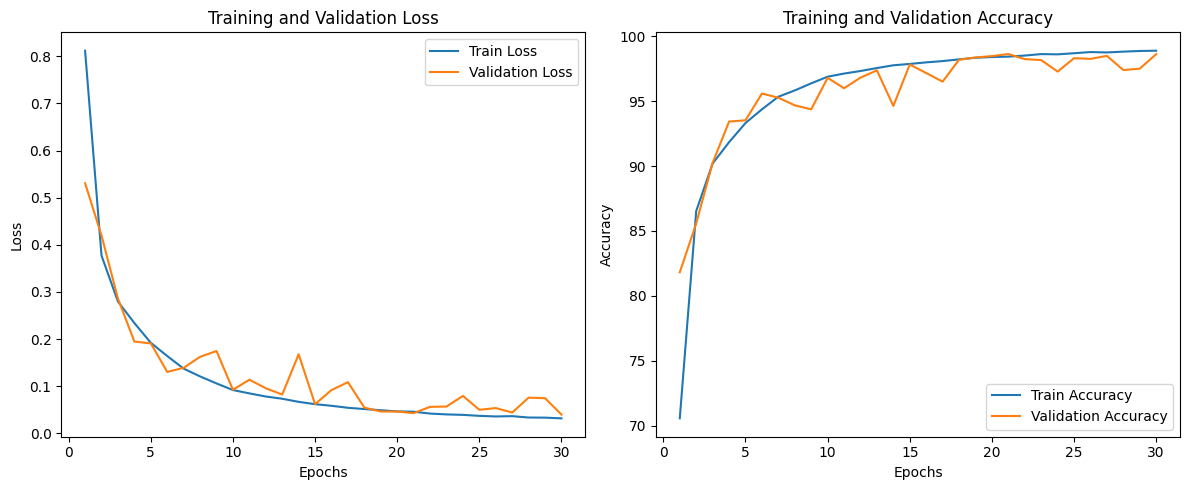

In [27]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 9.58 ms
Standard Deviation: 0.64 ms
Maximum Time: 13.80 ms
Minimum Time: 9.02 ms


In [29]:
evaluate(model, test_loader, criterion, device)

Validation: 100%|██████████| 469/469 [00:33<00:00, 14.16it/s]

Validation Loss: 0.0397, Validation Accuracy: 98.87%


In [30]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         2.33%     483.166us        24.84%       5.148ms     107.254us       0.000us         0.00%       5.075ms     105.731us            48  
                                           aten::linear         0.91%     189.340us        17.14%       3.551ms     104.453us       0.000us         0.00%       3.635ms     106.926us            34  
         

In [31]:
save_path = "HoViT44_NCT_CRC_HE_agu.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to HoViT44_NCT_CRC_HE_agu.pth


In [ ]:
save_path = "HoViT44_NCT_CRC_HE.pth"
model.load_state_dict(torch.load(save_path))

<ipython-input-33-393eca7ae88c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


<All keys matched successfully>

In [38]:
# 데이터셋 경로
dataset_dir = './val/CRC-VAL-HE-7K'

# 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #DataAugmentation(),
])

# 데이터셋 로드
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

In [39]:
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [40]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, full_loader, criterion, device)

Validation: 100%|██████████| 225/225 [00:11<00:00, 19.53it/s]


Validation Loss: 0.3762, Validation Accuracy: 90.33%
Overall - F1: 0.8945, Recall: 0.9030, Precision: 0.8992
Per-Class Metrics:
Class 0 - F1: 0.8772, Recall: 0.7982, Precision: 0.9736
Class 1 - F1: 0.9680, Recall: 1.0000, Precision: 0.9380
Class 2 - F1: 0.9026, Recall: 0.9705, Precision: 0.8436
Class 3 - F1: 0.9721, Recall: 0.9905, Precision: 0.9544
Class 4 - F1: 0.9132, Recall: 0.8899, Precision: 0.9379
Class 5 - F1: 0.7067, Recall: 0.8649, Precision: 0.5974
Class 6 - F1: 0.9463, Recall: 0.9636, Precision: 0.9297
Class 7 - F1: 0.8066, Recall: 0.6983, Precision: 0.9545
Class 8 - F1: 0.9576, Recall: 0.9513, Precision: 0.9638


<Figure size 2000x1200 with 0 Axes>

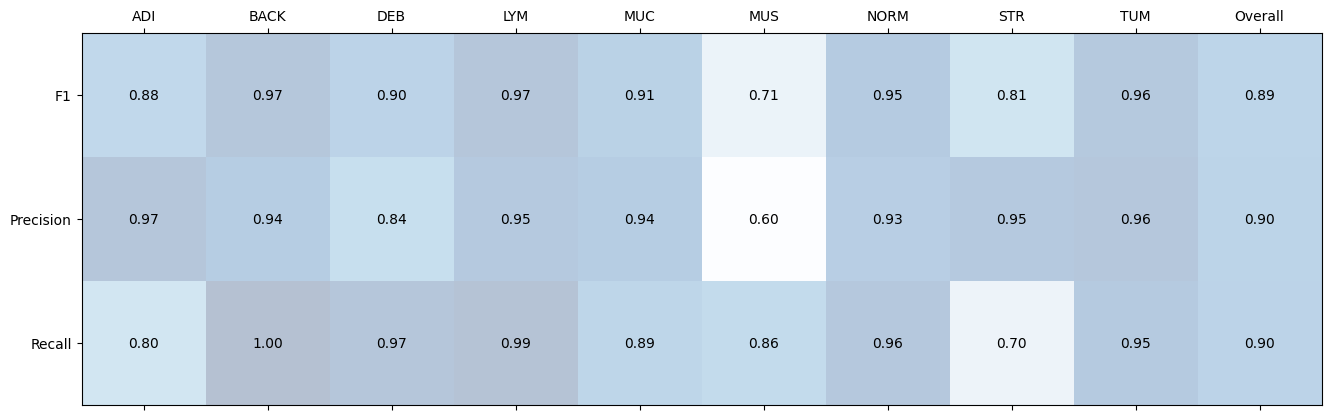

In [41]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )